In [1]:
from jax import jit, value_and_grad
import numpy as np
from qiskit_dynamics.array import wrap, Array
from qiskit_dynamics.pulse import InstructionToSignals
from scipy.optimize import minimize

from qiskit.scheduler.config import ScheduleConfig
from qiskit.scheduler.schedule_circuit import schedule_circuit
from qiskit import schedule as build_schedule
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit import QuantumCircuit
from qiskit.pulse import Schedule
from qiskit_dynamics import DynamicsBackend
from qiskit.providers import BackendV1
from qiskit_ibm_provider import IBMProvider
from qiskit.quantum_info.analysis import hellinger_fidelity

from casq import PulseCircuit, PulseSimulator, PulseBackendProperties
from casq.common import initialize_jax
from casq.gates import GaussianSquarePulseGate

initialize_jax()
# value_and_grad = wrap(jax.value_and_grad, decorator=True)
# jit = wrap(jax.jit, decorator=True)

# from jax.config import config
# config.update('jax_disable_jit', True)


In [2]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
config = backend.configuration()
dt = config.dt
props = backend.properties()
w = props.frequency(0)
solver_options = {"method": "DOP853"}
solver_options_jax = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}
dynamics_backend = DynamicsBackend.from_backend(
    backend=backend,
    subsystem_list=[0],
    solver_options=solver_options
)
simulator = PulseSimulator(
    solver=dynamics_backend.options.solver,
    experiment_result_function=PulseSimulator.get_experiment_result,
    solver_options=dynamics_backend.options.solver_options
)
dynamics_backend_jax = DynamicsBackend.from_backend(
    backend=backend,
    subsystem_list=[0],
    solver_options=solver_options_jax
)
simulator_jax = PulseSimulator(
    solver=dynamics_backend_jax.options.solver,
    experiment_result_function=PulseSimulator.get_experiment_result,
    solver_options=dynamics_backend_jax.options.solver_options
)


In [3]:
def build_gate(params):
    duration = 230
    amplitude = 1
    sigma, width = params
    return GaussianSquarePulseGate(duration, amplitude, sigma, width, jax=False, name="x")

def build_gate_jax(params):
    duration = 230
    amplitude = 1
    sigma, width = params
    return GaussianSquarePulseGate(duration, amplitude, sigma, width, jax=True, name="x")

def build_circuit(params):
    # return pulse.schedule(0, backend=backend, measured=True)
    return PulseCircuit.from_pulse(build_gate(params), backend, 0)

def build_circuit_jax(params):
    # return pulse.schedule(0, backend=backend, measured=True)
    return PulseCircuit.from_pulse(build_gate_jax(params), backend, 0)

def objective(params):
    circuit = build_circuit(params)
    counts = simulator.run(
        run_input=circuit,
    ).result().results[0].data.counts[1]
    target = {"0": 0, "1": 1024}
    fidelity = hellinger_fidelity(target, counts)
    return 1. - fidelity

def objective_jax(params):
    circuit = build_circuit_jax(params)
    counts = simulator_jax.run(
        run_input=circuit,
    ).result().results[0].data.counts[1]
    target = {"0": 0, "1": 1024}
    fidelity = hellinger_fidelity(target, counts)
    return 1. - fidelity

value_and_grad_obj = value_and_grad(objective_jax)
jit_grad_obj = jit(value_and_grad_obj)

initial_params = np.array([10., 10.])


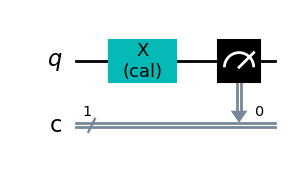

In [4]:
build_circuit(initial_params).draw("mpl")


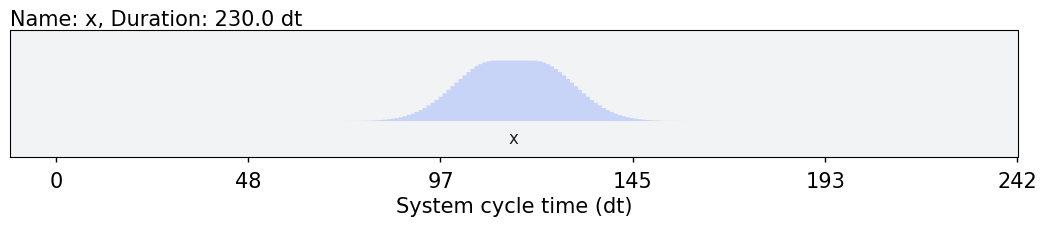

In [5]:
build_gate(initial_params).pulse().draw()

In [6]:
%%time
objective(initial_params)


CPU times: user 22 s, sys: 170 ms, total: 22.2 s
Wall time: 22.3 s


1.0

In [7]:
%%time
objective_jax(initial_params)


CPU times: user 855 ms, sys: 36.6 ms, total: 891 ms
Wall time: 875 ms


0.8505859375000001

In [8]:
%%time
jit_grad_obj(initial_params)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(complex128[3])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(complex128[3])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(complex128[3])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(complex128[3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x14b5d1ec0>, in_tracers=(Traced<ShapedArray(complex128[1,3]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x14ba357b0; to 'JaxprTracer' at 0x14ba35940>], out_avals=[ShapedArray(complex128[3])], primitive=squeeze, params={'dimensions': (0,)}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x14bb28d70>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [9]:
# %%time
# opt_results = minimize(fun=objective, x0=initial_params, jac=False, method="Nelder-Mead")
# print(opt_results.message)
# print(f"Optimized Sigma is {opt_results.x[0]} and Width is {opt_results.x[1]}")
# print('Number of function evaluations: ' + str(opt_results.nfev))
# print('Function value: ' + str(opt_results.fun))


In [10]:
%%time
opt_results = minimize(fun=objective_jax, x0=initial_params, jac=False, method="Nelder-Mead")
num_evaluations = opt_results.nfev
sigma_opt = opt_results.x[0]
width_opt = opt_results.x[1]
opt_value = opt_results.fun
print(opt_results.message)
print(f"Optimized Sigma is {sigma_opt} and Width is {width_opt}")
print('Number of function evaluations: ' + str(num_evaluations))
print('Function value: ' + str(opt_value))


Maximum number of function evaluations has been exceeded.
Optimized Sigma is 14.062499999999995 and Width is 10.687499999999984
Number of function evaluations: 400
Function value: 0.0009765625
CPU times: user 4min 30s, sys: 14.6 s, total: 4min 45s
Wall time: 4min 39s


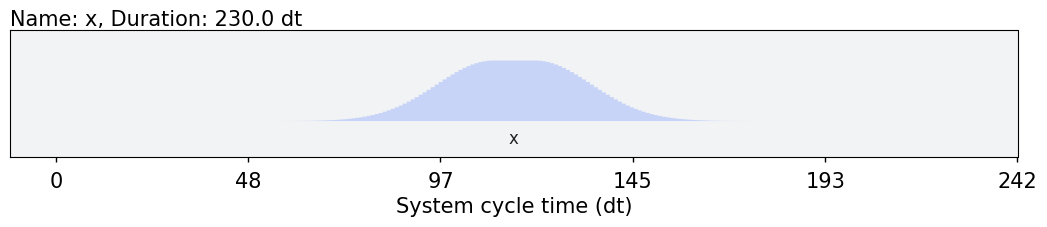

In [11]:
final_params = np.array([sigma_opt, width_opt])
build_gate(final_params).pulse().draw()


In [12]:
%%time
result = simulator_jax.run(build_circuit(final_params))
print(result.result().results[0].data.counts[1])


{'0': 8, '1': 1016}
CPU times: user 703 ms, sys: 43.7 ms, total: 747 ms
Wall time: 677 ms
